## Import library

In [8]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)
import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
import scipy.io
import random
from utilities3 import *
from FNO3D import *

import operator
from functools import reduce
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from torch.utils.data import TensorDataset, random_split, DataLoader

def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(202510)

mse_train = []
l2_test = []

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

2.5.1


/tmp/ipykernel_441307/2192371487.py:19: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


## Load selected testing data (the size should be [150, 10, 70, 70]-> [num_vel, num_src, nz, nx])

In [2]:
modes = 8
width = 16

epochs = 8000 #8000 for curvelet
learning_rate = 5e-4 #0.0025 for curvelet
scheduler_step = epochs//5
scheduler_gamma = 0.6
print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'pifnoeikonal_layer'
path_model = 'model_eikonal/'+path

runtime = np.zeros(2, )
t1 = time.time()


# Computational model parameters
zmin = 0.;  deltaz = 0.01; zmax = 0.7;
xmin = 0.;  deltax = 0.01; xmax = 0.7;

vel_train = np.load('./data/selected_vel_train.npy')
vel_test = np.load('./data/selected_vel_test.npy')
T0_data_train = np.load('./data/T0data_train.npy')
T0_data_test = np.load('./data/T0data_test.npy')
T_data_train = np.load('./data/Tdata_train.npy')
T_data_test = np.load('./data/Tdata_test.npy')


# Prepare training data
train_T_data = torch.Tensor(T_data_train)
train_T0_data = torch.Tensor(T0_data_train)
print(train_T_data.shape)
train_tau = train_T_data - train_T0_data
print('train_tau shape:', train_tau.shape)
nv, ns, nz, nx = train_T_data.shape[0], train_T_data.shape[1], train_T_data.shape[2], train_T_data.shape[3]
train_vel = torch.Tensor(np.array(vel_train)).repeat(ns, 1, 1, 1).permute(1, 0, 2, 3)
train_vel_right = 1/train_vel/train_vel
train_T0_input = torch.cat((train_vel_right.view(nv, ns, nz, nx, 1), 
                            train_T0_data.view(nv, ns, nz, nx, 1)), dim=-1)
print('shape of train T0 input:', train_T0_input.shape)

# Prepare testing data similarly
test_T_data = torch.Tensor(T_data_test)
test_T0_data = torch.Tensor(T0_data_test)
test_tau = test_T_data - test_T0_data
nv_test, ns_test, nz_test, nx_test = test_T_data.shape
test_vel = torch.Tensor(np.array(vel_test)).repeat(ns_test, 1, 1, 1).permute(1, 0, 2, 3)
test_vel_right = 1/test_vel/test_vel
test_T0_input = torch.cat((test_vel_right.view(nv_test, ns_test, nz_test, nx_test, 1), 
                           test_T0_data.view(nv_test, ns_test, nz_test, nx_test, 1)), dim=-1)
print('shape of test T0 input:', test_T0_input.shape)

8000 0.0005 1600 0.6
torch.Size([150, 10, 70, 70])
train_tau shape: torch.Size([150, 10, 70, 70])
shape of train T0 input: torch.Size([150, 10, 70, 70, 2])
shape of test T0 input: torch.Size([50, 10, 70, 70, 2])


## Training vel models visualization

torch.Size([150, 10, 70, 70])


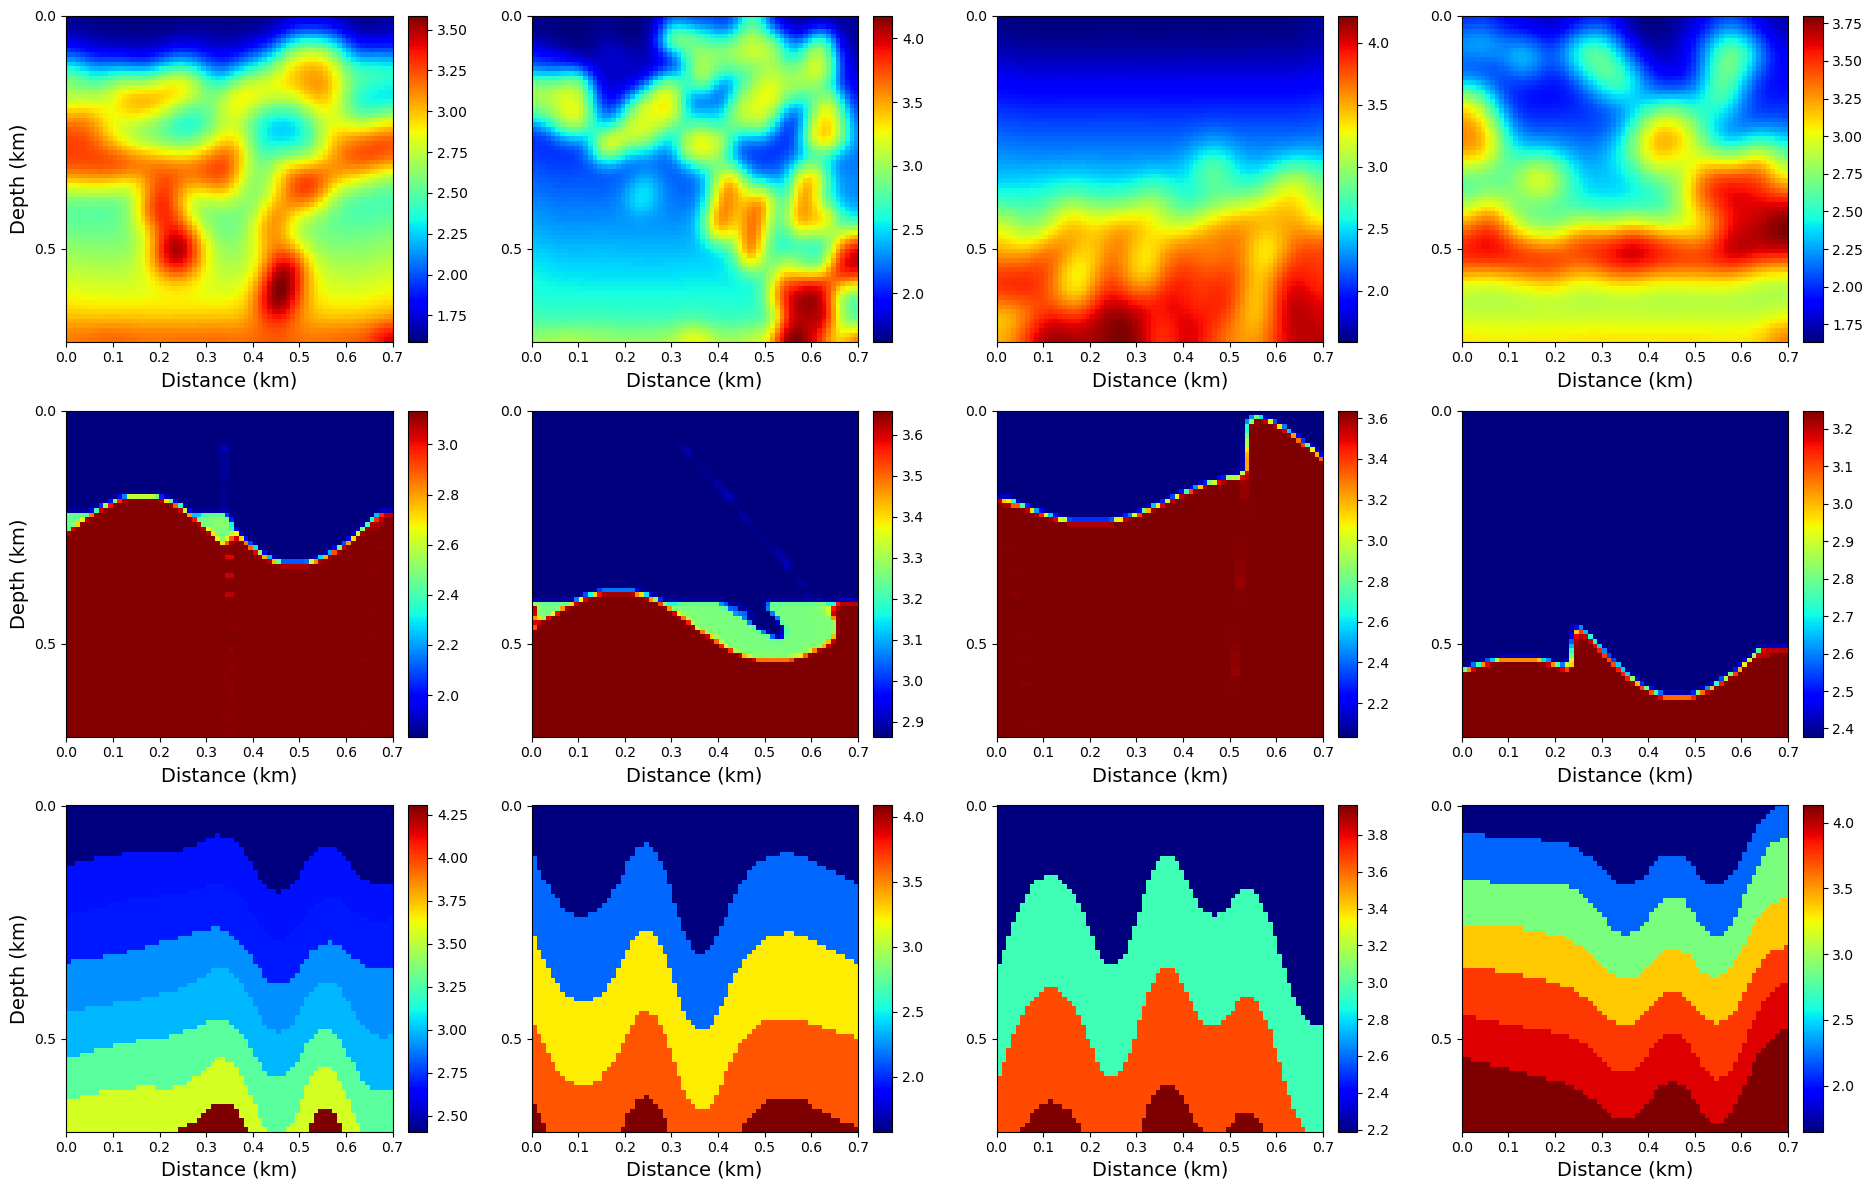

In [9]:
print(train_T_data.shape)

# Which source and velocity indices to visualize
isou = 5
vel_indices = [5, 20, 30, 35, 55, 65, 75, 85, 105, 115, 130, 135]  # 12 panels => 3 rows × 4 cols

plt.style.use('default')
fig, axes = plt.subplots(3, 4, figsize=(19, 12))
axes = axes.ravel()

for i, (ax, iv) in enumerate(zip(axes, vel_indices)):
    img = train_vel[iv, isou].detach().cpu().numpy() if hasattr(train_vel, 'detach') else train_vel[iv, isou]
    im = ax.imshow(
        img,
        extent=[xmin, xmax, zmax, zmin],  # depth downwards
        aspect=1,
        cmap='jet'
    )

    # Labels and ticks
    ax.set_xlabel('Distance (km)', fontsize=14)
    if i % 4 == 0:  # first column only
        ax.set_ylabel('Depth (km)', fontsize=14)
    ax.tick_params(labelsize=10)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    # Per-subplot colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="6%", pad=0.15)
    plt.colorbar(im, cax=cax)

plt.tight_layout()
# plt.savefig('./Fig/CurveVel.jpeg', dpi=400)
plt.show()

## Data augmentation

In [4]:
# For training: randomly split into train/val (e.g., 90/10)
X_train_full = train_T0_input
Y_train_full = train_vel_right
Z_train_full = train_tau
full_dataset = TensorDataset(X_train_full, Y_train_full, Z_train_full)

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test loader
test_dataset = TensorDataset(test_T0_input, test_vel_right, test_tau)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

print("train_T0_input:", train_T0_input.shape)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

model = Net3d(modes, width).to(device)

#model = torch.load(path_model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1*1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
mae = nn.L1Loss( reduction='sum')

Huber = nn.HuberLoss( reduction='sum')

train_T0_input: torch.Size([150, 10, 70, 70, 2])
Train samples: 135, Val samples: 15, Test samples: 50


## Model training

epoch: 0/8000, MSE loss: 4.34e+06, Accuracy: 27.41%, Epoch time: 1.75e+00s


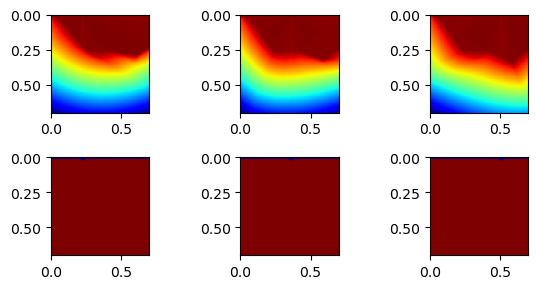

epoch: 100/8000, MSE loss: 1.92e+03, Accuracy: 68.83%, Epoch time: 1.47e+00s


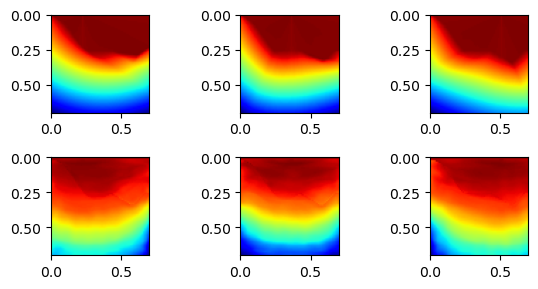

epoch: 200/8000, MSE loss: 1.26e+03, Accuracy: 78.25%, Epoch time: 1.48e+00s


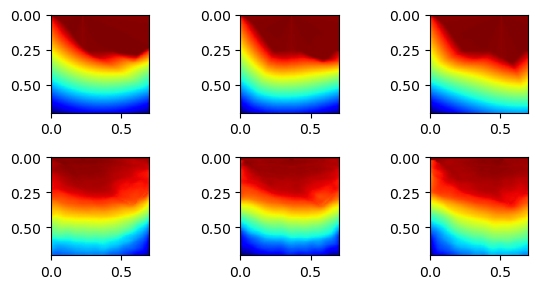

epoch: 300/8000, MSE loss: 1.01e+03, Accuracy: 79.66%, Epoch time: 1.47e+00s


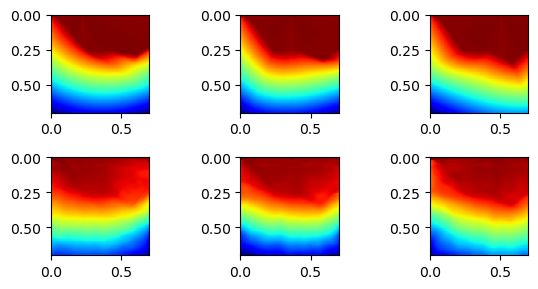

epoch: 400/8000, MSE loss: 8.94e+02, Accuracy: 81.68%, Epoch time: 1.48e+00s


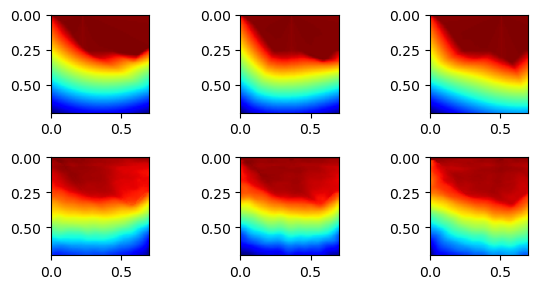

epoch: 500/8000, MSE loss: 7.01e+02, Accuracy: 83.40%, Epoch time: 1.48e+00s


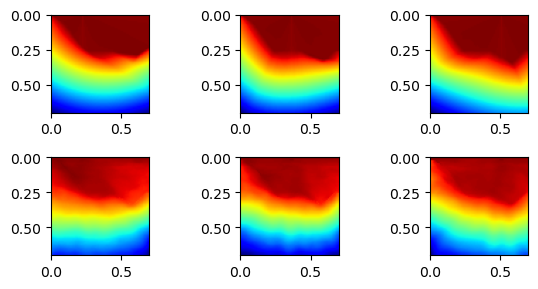

epoch: 600/8000, MSE loss: 6.05e+02, Accuracy: 84.49%, Epoch time: 1.48e+00s


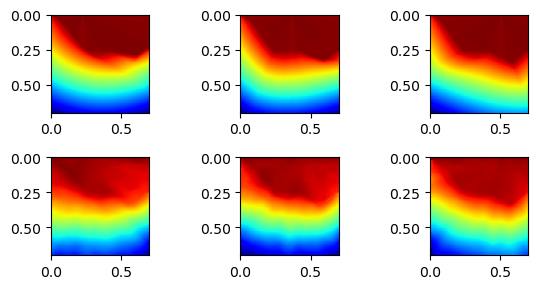

epoch: 700/8000, MSE loss: 6.39e+02, Accuracy: 84.86%, Epoch time: 1.47e+00s


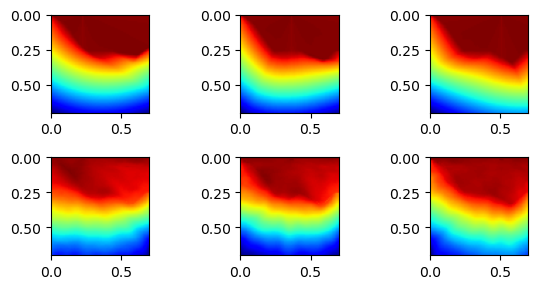

epoch: 800/8000, MSE loss: 4.66e+02, Accuracy: 85.67%, Epoch time: 1.47e+00s


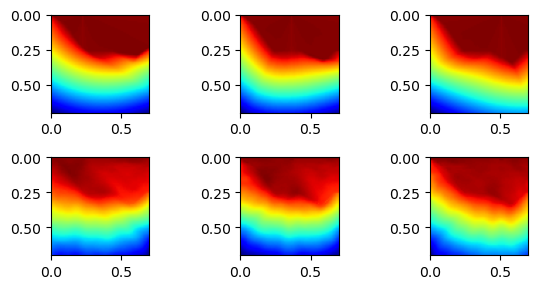

epoch: 900/8000, MSE loss: 3.71e+02, Accuracy: 86.02%, Epoch time: 1.47e+00s


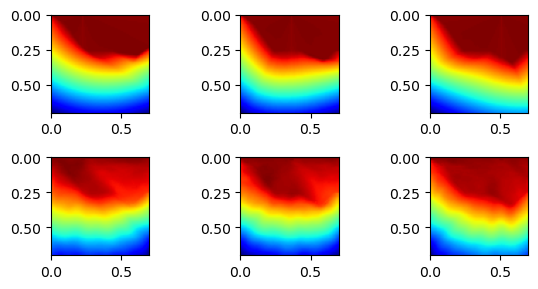

epoch: 1000/8000, MSE loss: 4.12e+02, Accuracy: 86.12%, Epoch time: 1.47e+00s


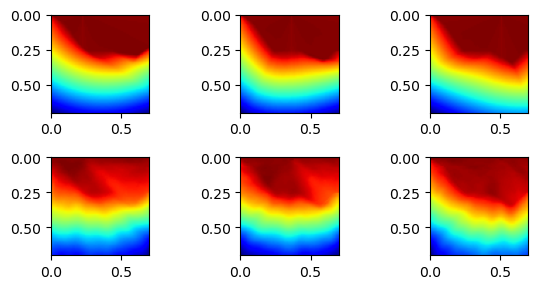

epoch: 1100/8000, MSE loss: 3.38e+02, Accuracy: 86.04%, Epoch time: 1.47e+00s


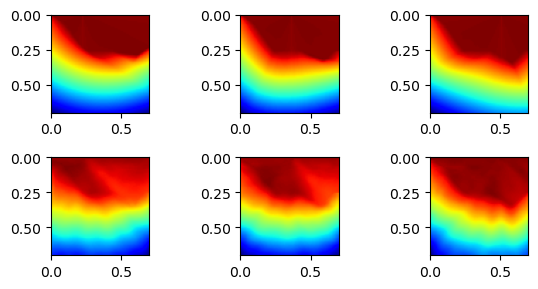

epoch: 1200/8000, MSE loss: 3.13e+02, Accuracy: 86.67%, Epoch time: 1.47e+00s


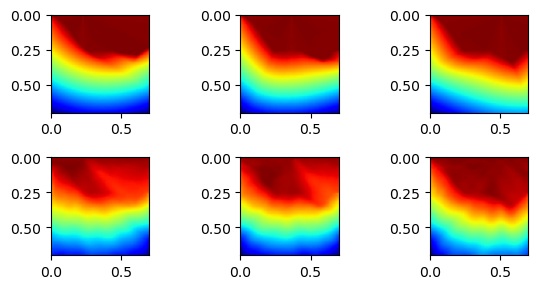

epoch: 1300/8000, MSE loss: 2.95e+02, Accuracy: 87.06%, Epoch time: 1.47e+00s


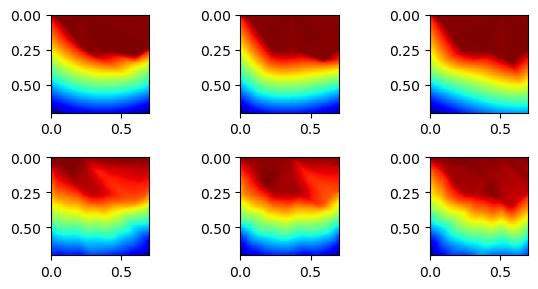

epoch: 1400/8000, MSE loss: 3.43e+02, Accuracy: 87.14%, Epoch time: 1.48e+00s


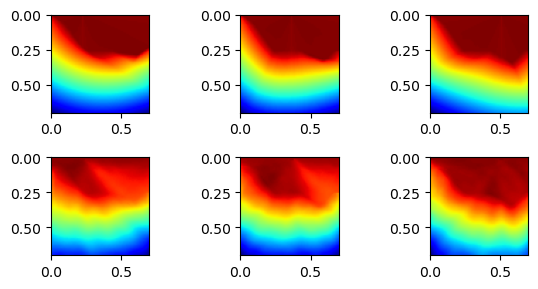

epoch: 1500/8000, MSE loss: 2.93e+02, Accuracy: 86.82%, Epoch time: 1.47e+00s


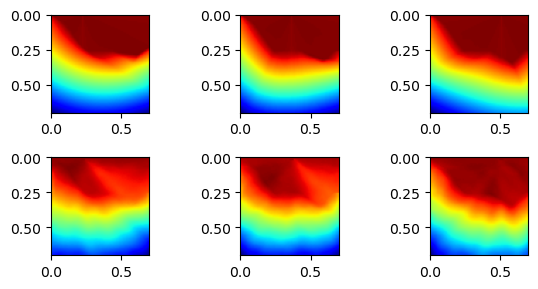

epoch: 1600/8000, MSE loss: 2.65e+02, Accuracy: 87.64%, Epoch time: 1.47e+00s


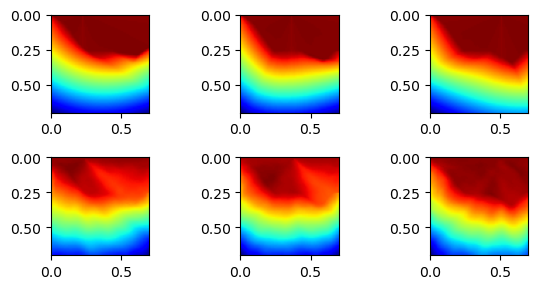

epoch: 1700/8000, MSE loss: 2.53e+02, Accuracy: 87.69%, Epoch time: 1.47e+00s


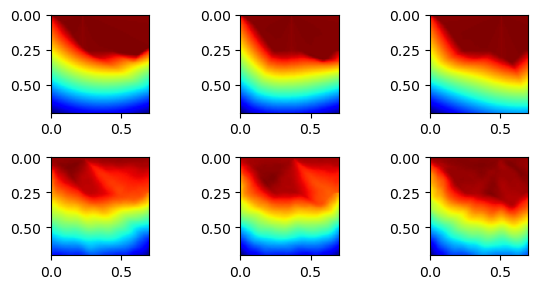

epoch: 1800/8000, MSE loss: 2.30e+02, Accuracy: 87.80%, Epoch time: 1.47e+00s


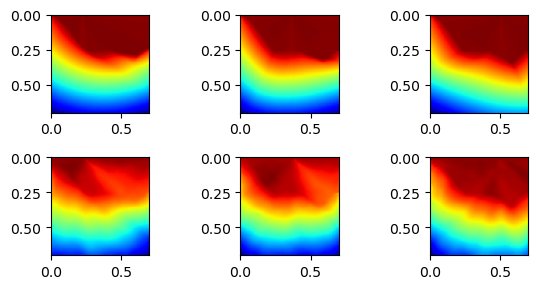

epoch: 1900/8000, MSE loss: 2.32e+02, Accuracy: 87.86%, Epoch time: 1.47e+00s


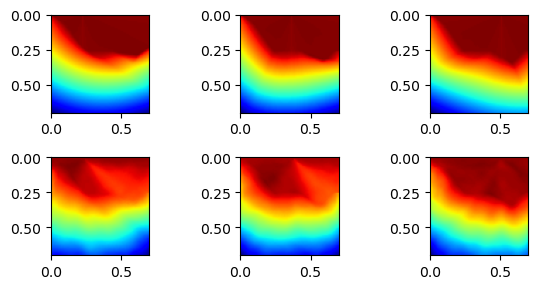

epoch: 2000/8000, MSE loss: 2.43e+02, Accuracy: 87.84%, Epoch time: 1.47e+00s


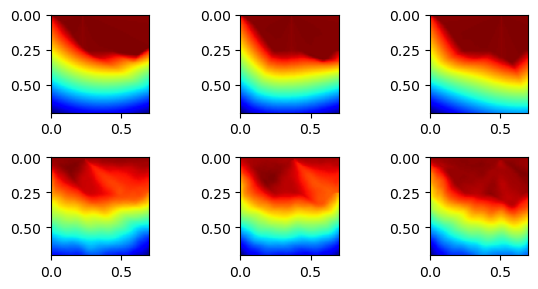

epoch: 2100/8000, MSE loss: 2.76e+02, Accuracy: 87.04%, Epoch time: 1.47e+00s


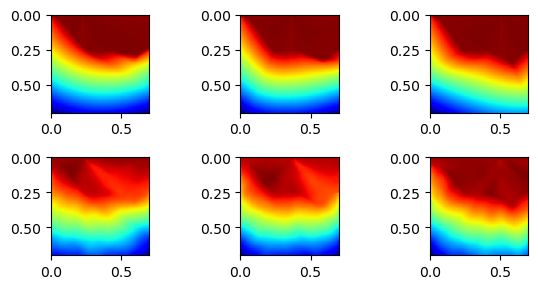

epoch: 2200/8000, MSE loss: 2.08e+02, Accuracy: 87.99%, Epoch time: 1.48e+00s


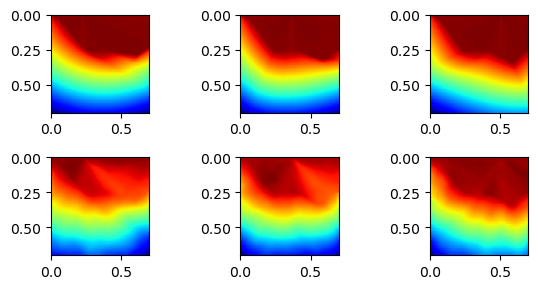

epoch: 2300/8000, MSE loss: 2.00e+02, Accuracy: 87.98%, Epoch time: 1.47e+00s


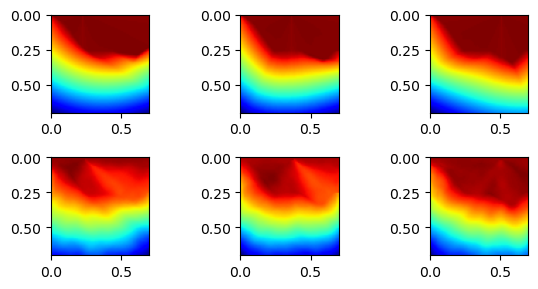

epoch: 2400/8000, MSE loss: 2.18e+02, Accuracy: 88.31%, Epoch time: 1.47e+00s


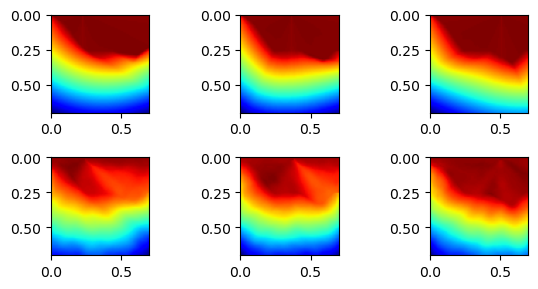

epoch: 2500/8000, MSE loss: 2.15e+02, Accuracy: 88.13%, Epoch time: 1.47e+00s


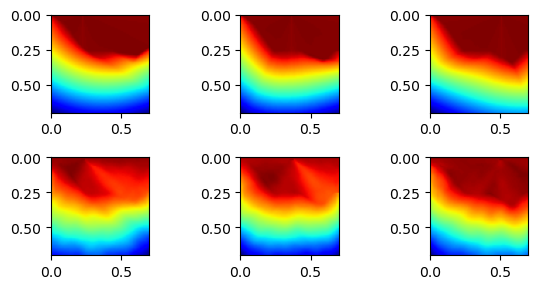

epoch: 2600/8000, MSE loss: 1.99e+02, Accuracy: 87.77%, Epoch time: 1.48e+00s


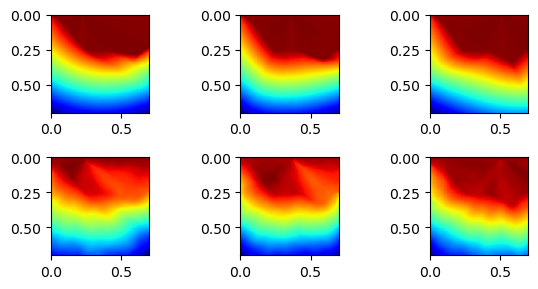

epoch: 2700/8000, MSE loss: 2.11e+02, Accuracy: 88.24%, Epoch time: 1.48e+00s


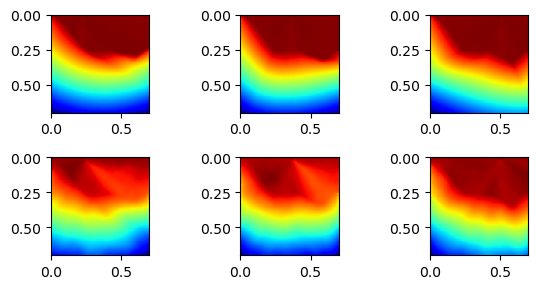

epoch: 2800/8000, MSE loss: 1.97e+02, Accuracy: 88.38%, Epoch time: 1.48e+00s


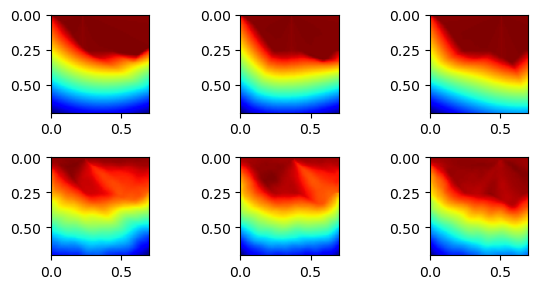

epoch: 2900/8000, MSE loss: 2.31e+02, Accuracy: 87.58%, Epoch time: 1.47e+00s


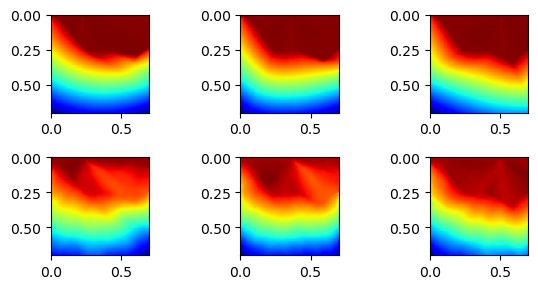

epoch: 3000/8000, MSE loss: 1.99e+02, Accuracy: 88.28%, Epoch time: 1.48e+00s


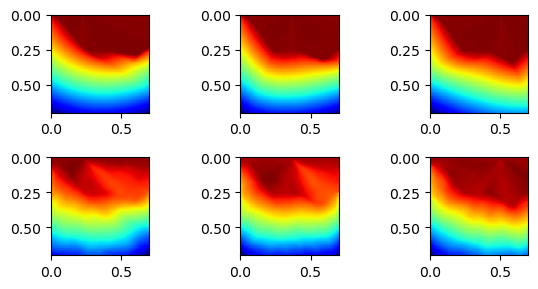

epoch: 3100/8000, MSE loss: 1.99e+02, Accuracy: 88.24%, Epoch time: 1.48e+00s


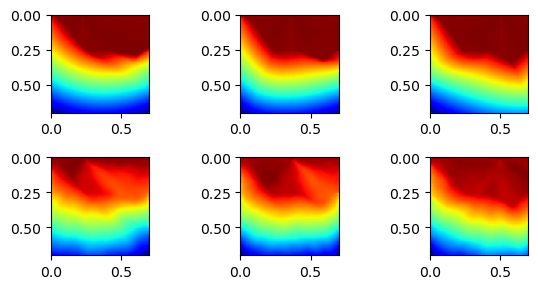

epoch: 3200/8000, MSE loss: 2.02e+02, Accuracy: 88.30%, Epoch time: 1.48e+00s


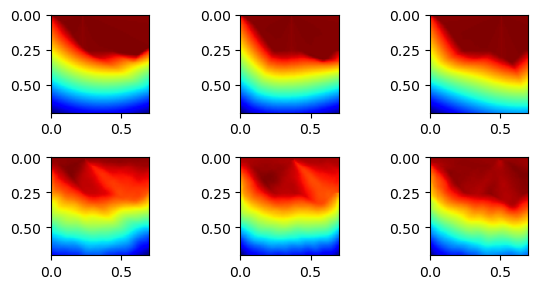

epoch: 3300/8000, MSE loss: 1.65e+02, Accuracy: 88.61%, Epoch time: 1.48e+00s


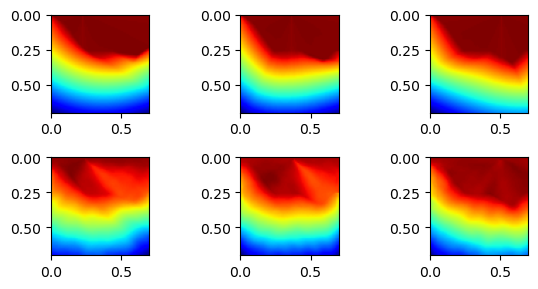

epoch: 3400/8000, MSE loss: 1.79e+02, Accuracy: 88.47%, Epoch time: 1.48e+00s


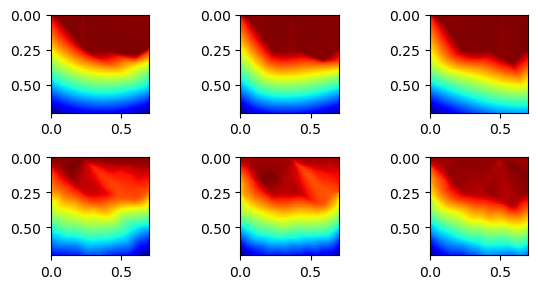

epoch: 3500/8000, MSE loss: 1.72e+02, Accuracy: 88.59%, Epoch time: 1.48e+00s


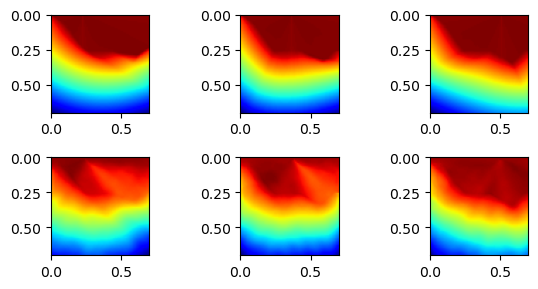

epoch: 3600/8000, MSE loss: 1.74e+02, Accuracy: 88.42%, Epoch time: 1.48e+00s


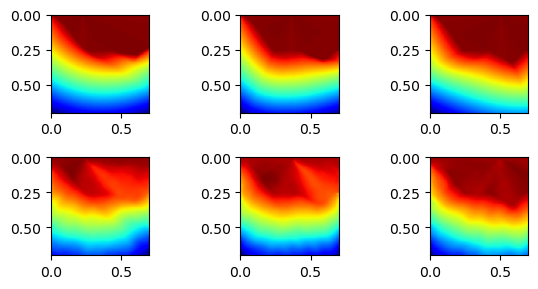

epoch: 3700/8000, MSE loss: 1.84e+02, Accuracy: 88.03%, Epoch time: 1.48e+00s


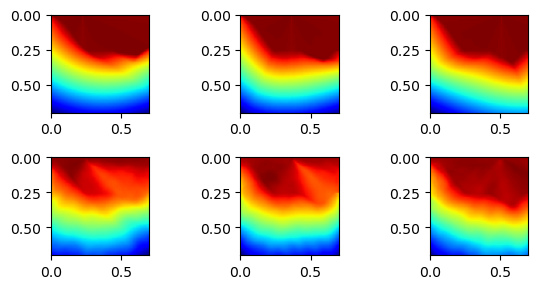

epoch: 3800/8000, MSE loss: 1.79e+02, Accuracy: 88.59%, Epoch time: 1.48e+00s


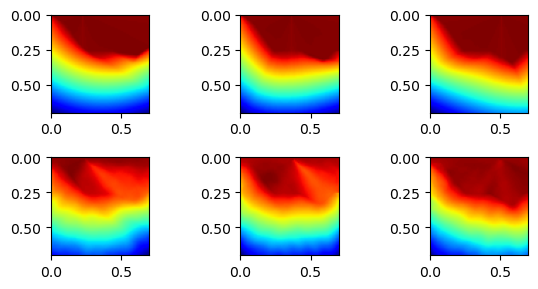

epoch: 3900/8000, MSE loss: 1.72e+02, Accuracy: 88.62%, Epoch time: 1.48e+00s


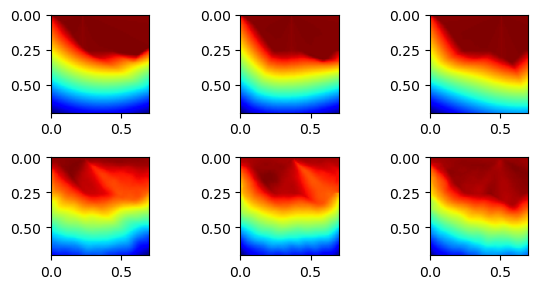

epoch: 4000/8000, MSE loss: 1.71e+02, Accuracy: 88.75%, Epoch time: 1.48e+00s


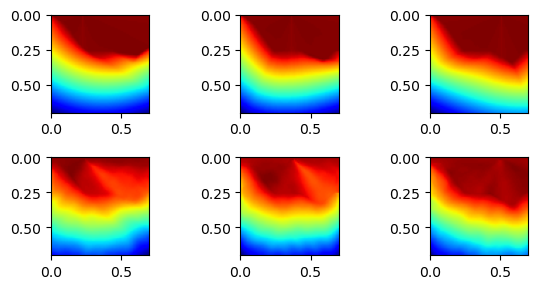

epoch: 4100/8000, MSE loss: 1.74e+02, Accuracy: 88.47%, Epoch time: 1.48e+00s


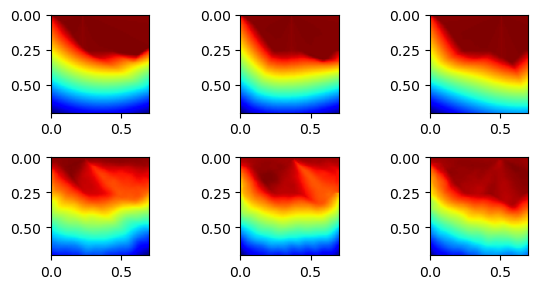

epoch: 4200/8000, MSE loss: 1.72e+02, Accuracy: 88.67%, Epoch time: 1.48e+00s


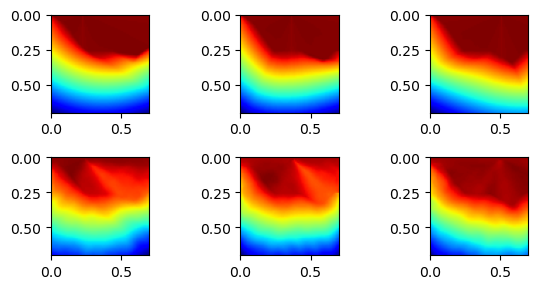

epoch: 4300/8000, MSE loss: 1.80e+02, Accuracy: 88.80%, Epoch time: 1.48e+00s


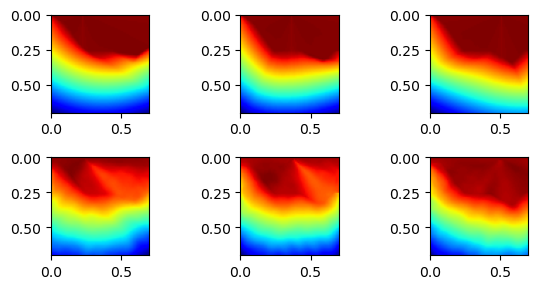

epoch: 4400/8000, MSE loss: 1.64e+02, Accuracy: 88.80%, Epoch time: 1.48e+00s


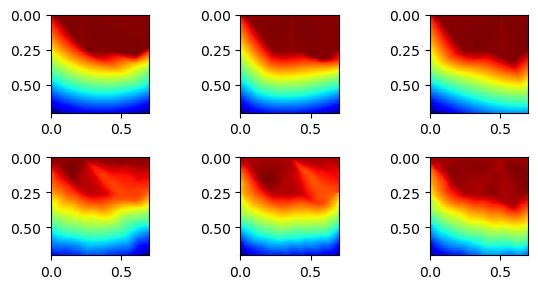

epoch: 4500/8000, MSE loss: 1.63e+02, Accuracy: 88.71%, Epoch time: 1.47e+00s


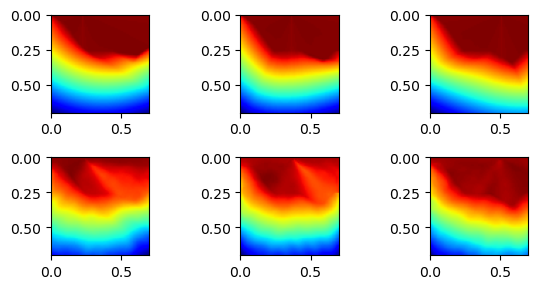

epoch: 4600/8000, MSE loss: 1.57e+02, Accuracy: 88.78%, Epoch time: 1.47e+00s


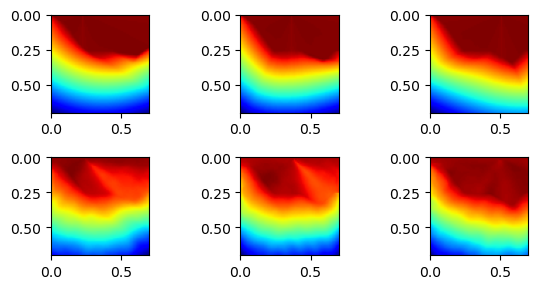

epoch: 4700/8000, MSE loss: 1.53e+02, Accuracy: 88.87%, Epoch time: 1.48e+00s


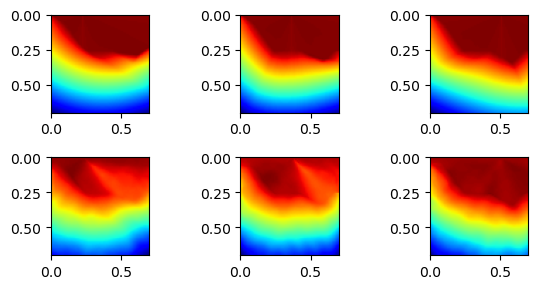

epoch: 4800/8000, MSE loss: 1.68e+02, Accuracy: 88.98%, Epoch time: 1.48e+00s


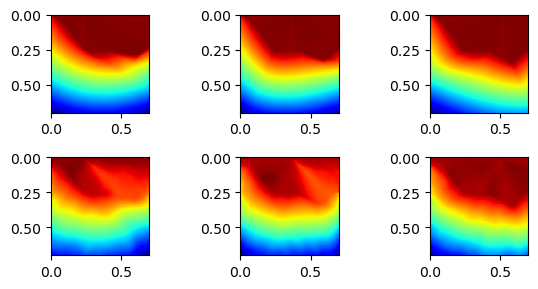

epoch: 4900/8000, MSE loss: 1.59e+02, Accuracy: 88.90%, Epoch time: 1.48e+00s


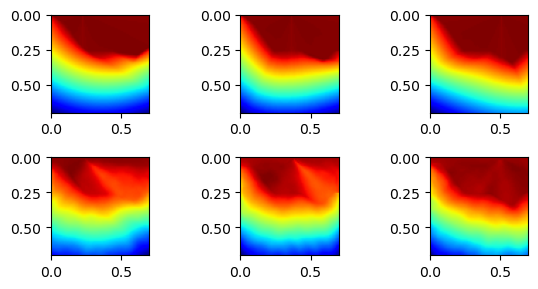

epoch: 5000/8000, MSE loss: 1.70e+02, Accuracy: 88.91%, Epoch time: 1.48e+00s


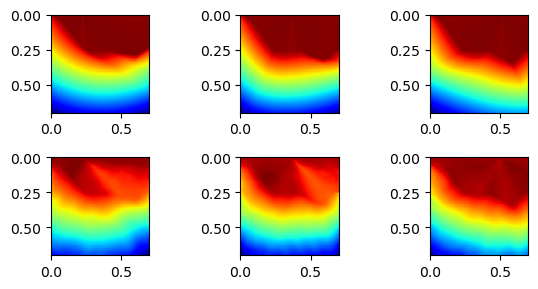

epoch: 5100/8000, MSE loss: 1.52e+02, Accuracy: 88.89%, Epoch time: 1.48e+00s


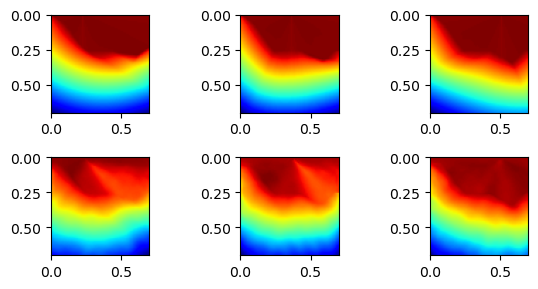

epoch: 5200/8000, MSE loss: 1.53e+02, Accuracy: 88.58%, Epoch time: 1.47e+00s


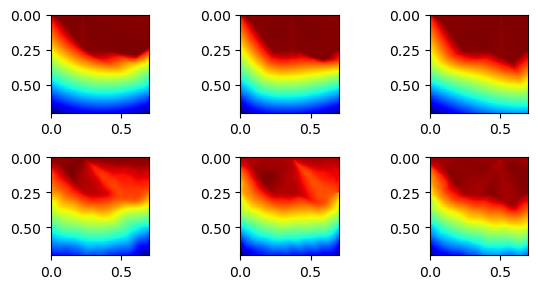

epoch: 5300/8000, MSE loss: 1.54e+02, Accuracy: 88.99%, Epoch time: 1.48e+00s


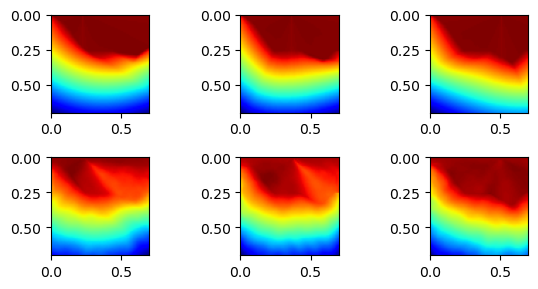

epoch: 5400/8000, MSE loss: 1.49e+02, Accuracy: 88.71%, Epoch time: 1.48e+00s


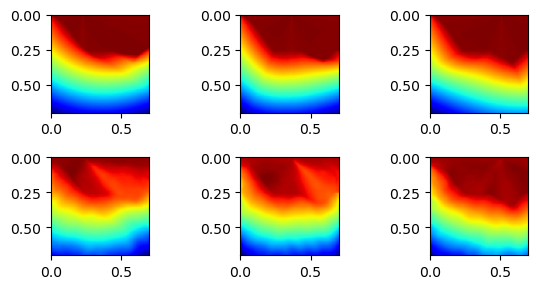

epoch: 5500/8000, MSE loss: 1.49e+02, Accuracy: 88.81%, Epoch time: 1.48e+00s


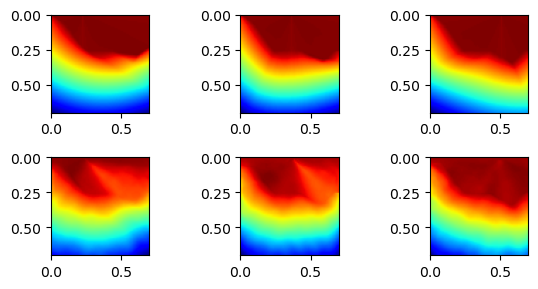

epoch: 5600/8000, MSE loss: 1.65e+02, Accuracy: 88.74%, Epoch time: 1.48e+00s


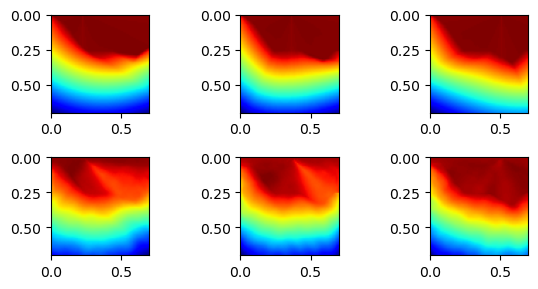

epoch: 5700/8000, MSE loss: 1.48e+02, Accuracy: 88.71%, Epoch time: 1.48e+00s


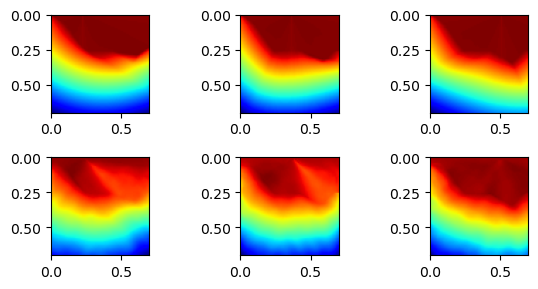

epoch: 5800/8000, MSE loss: 1.50e+02, Accuracy: 89.05%, Epoch time: 1.48e+00s


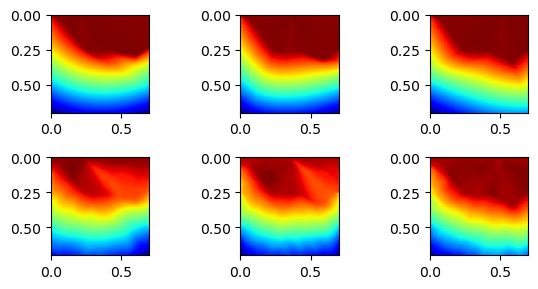

epoch: 5900/8000, MSE loss: 1.47e+02, Accuracy: 88.87%, Epoch time: 1.48e+00s


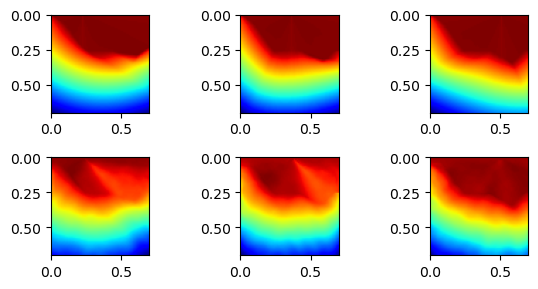

epoch: 6000/8000, MSE loss: 1.50e+02, Accuracy: 88.90%, Epoch time: 1.48e+00s


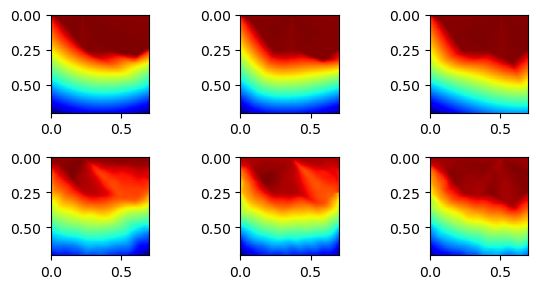

epoch: 6100/8000, MSE loss: 1.51e+02, Accuracy: 88.96%, Epoch time: 1.47e+00s


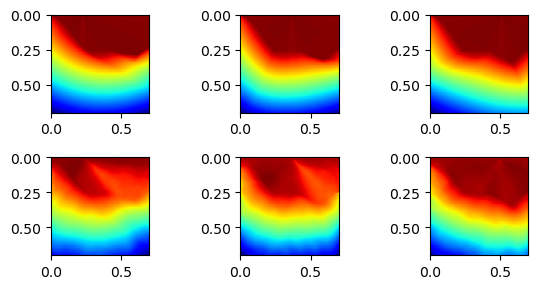

epoch: 6200/8000, MSE loss: 1.41e+02, Accuracy: 89.00%, Epoch time: 1.47e+00s


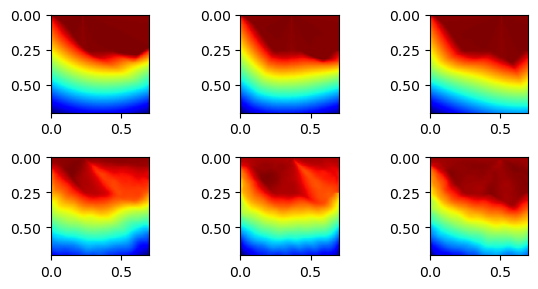

epoch: 6300/8000, MSE loss: 1.46e+02, Accuracy: 88.99%, Epoch time: 1.48e+00s


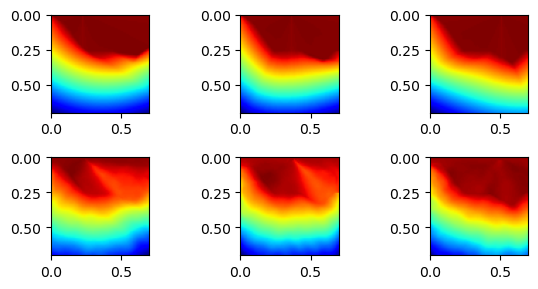

epoch: 6400/8000, MSE loss: 1.52e+02, Accuracy: 88.80%, Epoch time: 1.48e+00s


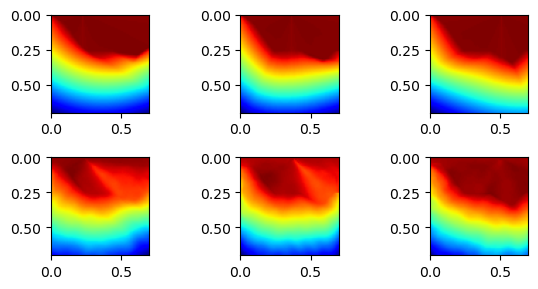

epoch: 6500/8000, MSE loss: 1.42e+02, Accuracy: 88.92%, Epoch time: 1.48e+00s


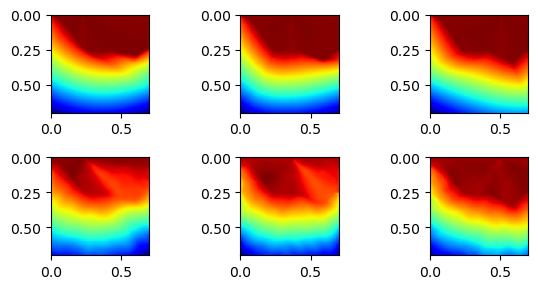

epoch: 6600/8000, MSE loss: 1.43e+02, Accuracy: 89.04%, Epoch time: 1.48e+00s


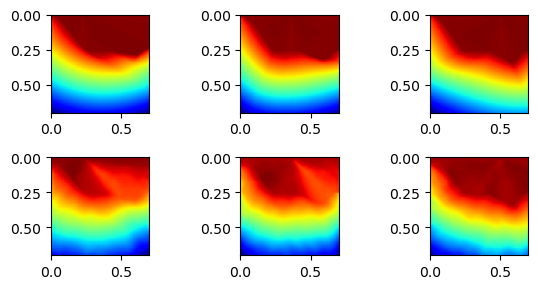

epoch: 6700/8000, MSE loss: 1.47e+02, Accuracy: 88.89%, Epoch time: 1.47e+00s


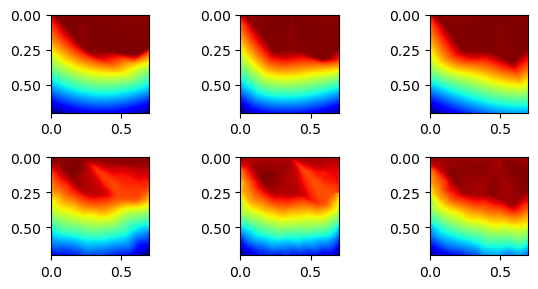

epoch: 6800/8000, MSE loss: 1.43e+02, Accuracy: 88.92%, Epoch time: 1.48e+00s


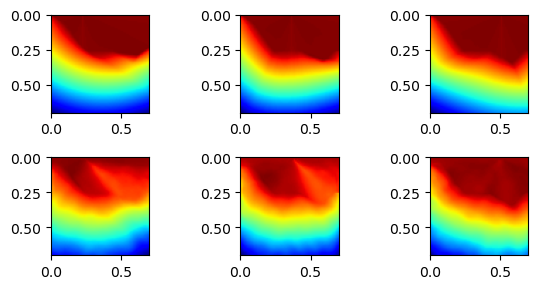

epoch: 6900/8000, MSE loss: 1.44e+02, Accuracy: 88.90%, Epoch time: 1.48e+00s


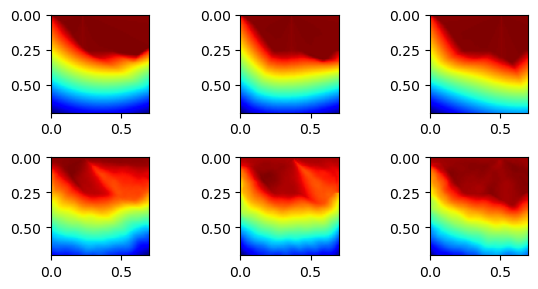

epoch: 7000/8000, MSE loss: 1.43e+02, Accuracy: 88.99%, Epoch time: 1.48e+00s


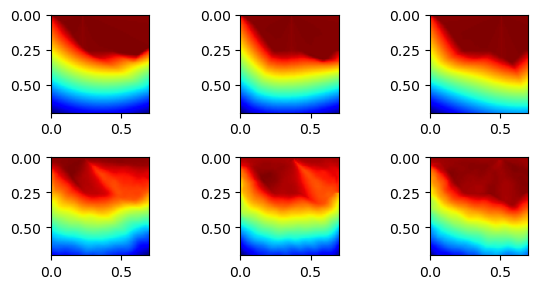

epoch: 7100/8000, MSE loss: 1.43e+02, Accuracy: 89.01%, Epoch time: 1.48e+00s


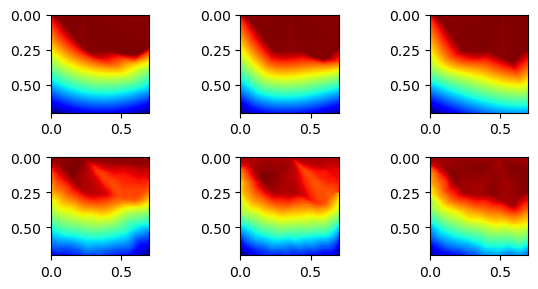

epoch: 7200/8000, MSE loss: 1.45e+02, Accuracy: 88.99%, Epoch time: 1.47e+00s


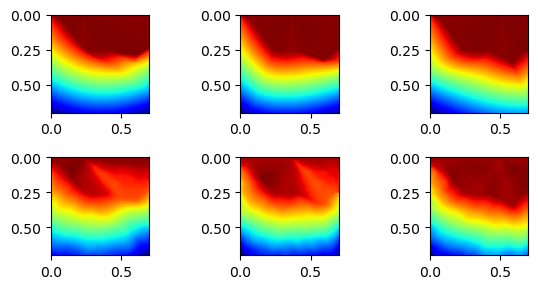

epoch: 7300/8000, MSE loss: 1.49e+02, Accuracy: 88.98%, Epoch time: 1.47e+00s


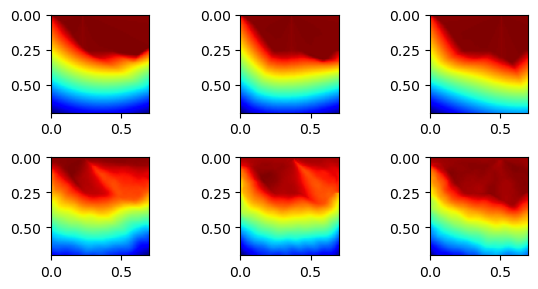

epoch: 7400/8000, MSE loss: 1.41e+02, Accuracy: 89.10%, Epoch time: 1.48e+00s


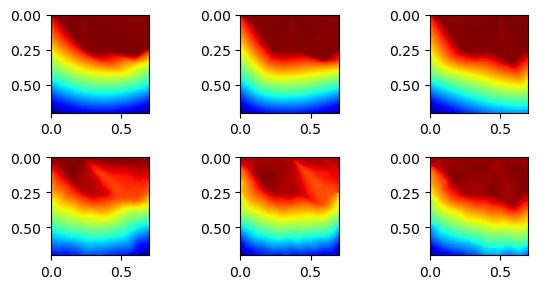

epoch: 7500/8000, MSE loss: 1.44e+02, Accuracy: 89.04%, Epoch time: 1.48e+00s


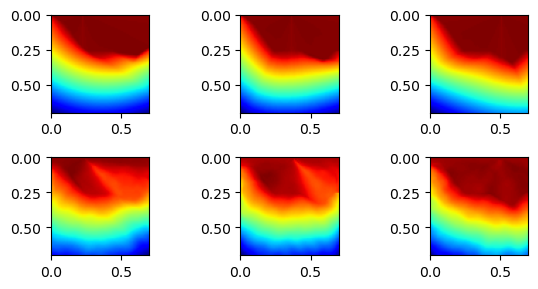

epoch: 7600/8000, MSE loss: 1.46e+02, Accuracy: 89.04%, Epoch time: 1.48e+00s


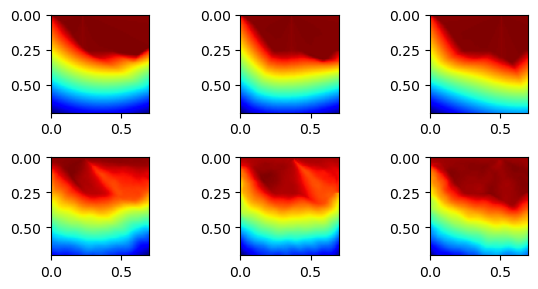

epoch: 7700/8000, MSE loss: 1.42e+02, Accuracy: 89.00%, Epoch time: 1.48e+00s


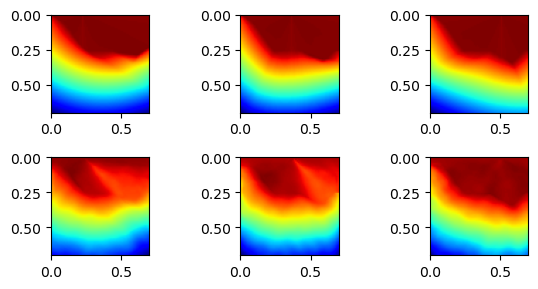

epoch: 7800/8000, MSE loss: 1.46e+02, Accuracy: 89.05%, Epoch time: 1.48e+00s


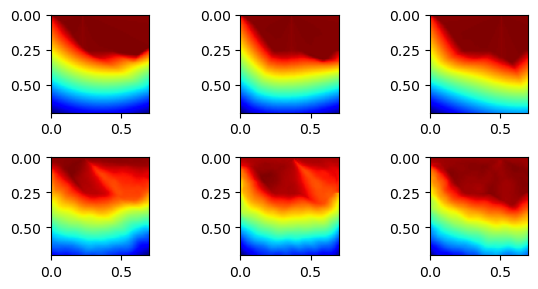

epoch: 7900/8000, MSE loss: 1.40e+02, Accuracy: 89.05%, Epoch time: 1.47e+00s


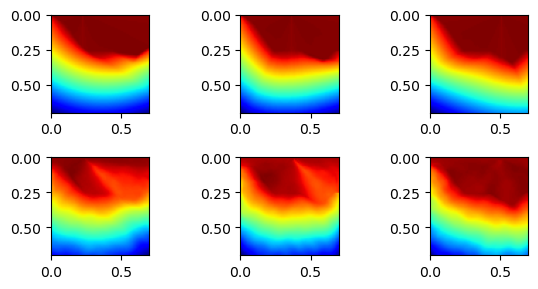

Final trained model saved
Total training time for 8000 epochs: 11829.39 seconds
Average time per epoch: 1.48 seconds


In [5]:
import time  # Ensure time is imported if not already

##################################################
########### training and evaluation###############
##################################################
total_t1 = time.time()
epoch_times = []


for ep in range(epochs):
    model.train()
    t1 = time.time()
    train_mse = 0
    for x, y, z in train_loader:
        x, y, z = x.to(device), y.to(device), z.to(device)
        
        optimizer.zero_grad()
        tau, loss = model(x, y)
        #mse = torch.sum(torch.pow(loss[:,:,1:-1,1:-1],2)) + 0.0001*torch.sum(torch.pow(tau[:,:,1:-1,1:-1],2))
        mse = torch.sum(torch.pow(loss[:,:,1:-1,1:-1],2)) 
        mse.backward()

        optimizer.step()
        train_mse += mse.item()

    scheduler.step()
    model.eval()

    train_mse /= len(train_loader)

    # Evaluation (no augmentation)
    eval_t1 = time.time()
    test_l2 = 0
    base = 0
    for x1, y1, z1 in val_loader:
        x1, y1, z1 = x1.to(device), y1.to(device), z1.to(device)
        pred, _ = model(x1, y1)
        test_l2 += myloss(torch.abs(pred.reshape(ns, -1)), torch.abs(z1.reshape(ns, -1))).item() 
        base += myloss(pred.reshape(ns, -1)*0, torch.abs(z1.reshape(ns, -1))).item() 

    
    accuracy = (1.0 - test_l2 / base) * 100
    l2_test.append(accuracy)
    
    eval_t2 = time.time()
    eval_time = eval_t2 - eval_t1
    t2 = time.time()  
    epoch_time = t2 - t1
    epoch_times.append(epoch_time)
    mse_train.append(train_mse)
    
    if (ep % 100 == 0):
        #torch.save(model, path_model+'_epoch%(d)'%(ep))
        # torch.save(model, path_model)
        # print('epoch:',ep, 'MSE loss:',train_mse, 'Accuracy(%):', accuracy)
        print(f'epoch: {ep}/{epochs}, MSE loss: {train_mse:.2e}, Accuracy: {accuracy:.2f}%, Epoch time: {epoch_time:.2e}s')
       
        # Use sample for plotting
        if z1 is not None and pred is not None:
            plt.figure(figsize=(6,3))
            plt.subplot(2,3,1)
            ax = plt.gca()
            im = ax.imshow(z1[0,3,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
            plt.subplot(2,3,2)
            ax = plt.gca()
            im = ax.imshow(z1[0,5,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
            plt.subplot(2,3,3)
            ax = plt.gca()
            im = ax.imshow(z1[0,7,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
            plt.subplot(2,3,4)
            ax = plt.gca()
            im = ax.imshow(pred[0,3,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
            plt.subplot(2,3,5)
            ax = plt.gca()
            im = ax.imshow(pred[0,5,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
            plt.subplot(2,3,6)
            ax = plt.gca()
            im = ax.imshow(pred[0,7,:,:].cpu().detach().numpy(), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")
            plt.tight_layout()
            plt.show()

# Save the final trained model
torch.save(model.state_dict(), f'./models/multi_family_ep{epochs}_physics_driven.pth')
print(f'Final trained model saved')

total_t2 = time.time()
total_time = total_t2 - total_t1
print(f'Total training time for {epochs} epochs: {total_time:.2f} seconds')
print(f'Average time per epoch: {sum(epoch_times)/len(epoch_times):.2f} seconds')

## Loss curve visualization

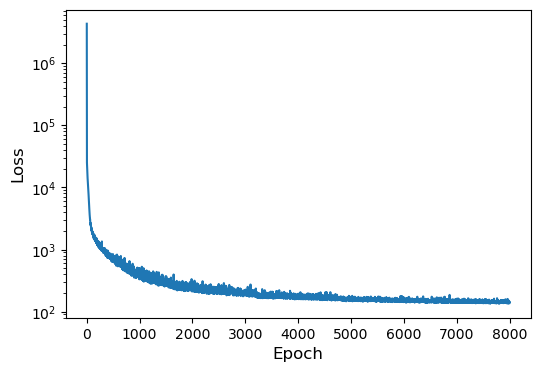

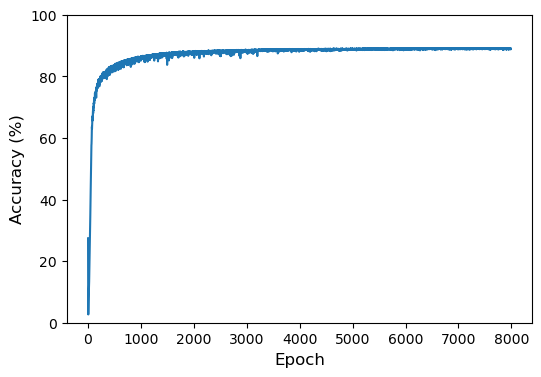

In [6]:
N = epochs
plt.figure(figsize=(6,4))
#plt.subplot(1,2,1)
plt.plot(mse_train)
plt.yscale('log')
plt.xlabel("Epoch", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Loss", fontsize=12)
plt.yticks(fontsize=10)
plt.savefig('./figs/Loss_curve_physics_informed.png',dpi=400)

plt.figure(figsize=(6,4))
plt.plot(l2_test[:-10])
# plt.yscale('log')
plt.xlabel("Epoch", fontsize=12)
plt.xticks(fontsize=10)
plt.ylim([0, 100])
plt.ylabel("Accuracy (%)", fontsize=12)
plt.yticks(fontsize=10)
plt.savefig('./figs/Accuracy_curve_physics_informed.png',dpi=400)
#plt.savefig('./Fig/Loss_layer.jpeg',dpi=400)